<a href="https://colab.research.google.com/github/mahditeymori/mahditeymori/blob/main/classification_with%20search%20Grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Install the SHAP package for model explainability
# !pip install shap


In [2]:
!pip install xgboost
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 7.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [3]:
#conect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import necessary libraries for data processing, modeling, and visualization
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.tree import plot_tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset from an Excel file
data = pd.read_excel('/content/drive/MyDrive/Dry_Bean_Dataset.xlsx')
# Display the first few rows of the dataset
print(data.head())

    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332  

In [5]:
# Display information about the dataset, such as data types and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [6]:
# Display statistical summary of the dataset
data.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


In [7]:
# Check for missing values in the dataset
data.isnull().sum()

,0
Area,0
Perimeter,0
MajorAxisLength,0
MinorAxisLength,0
AspectRation,0
Eccentricity,0
ConvexArea,0
EquivDiameter,0
Extent,0
Solidity,0


<Axes: >

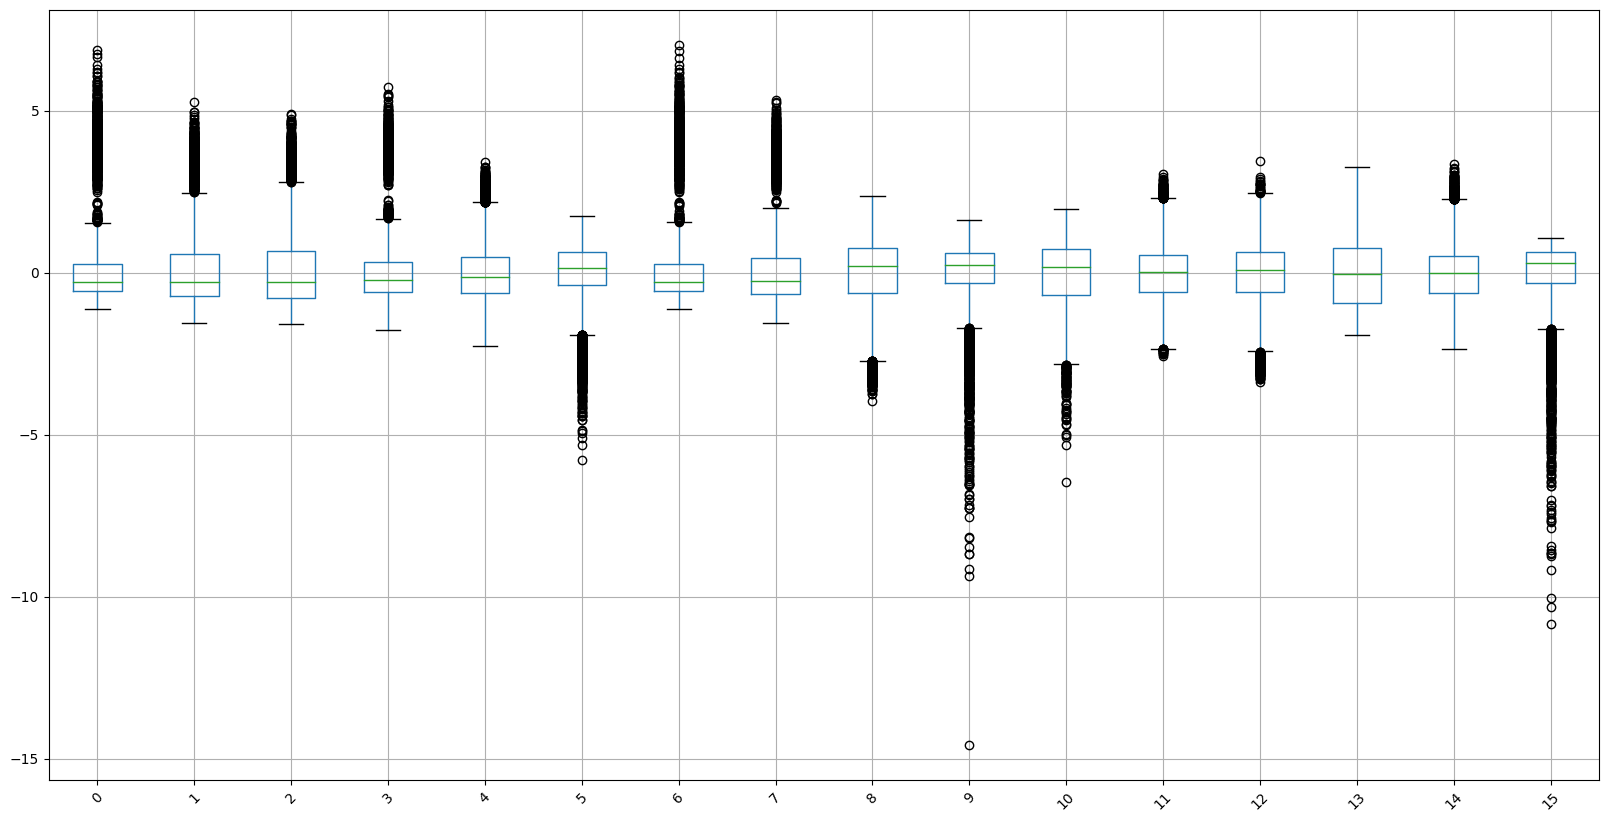

In [8]:
# Boxplot to visualize the distribution of features after scaling
x = data.drop(['Class'], axis=1)
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(x)
x.boxplot(rot=45, figsize=(20,10))

<Axes: xlabel='Class', ylabel='Area'>

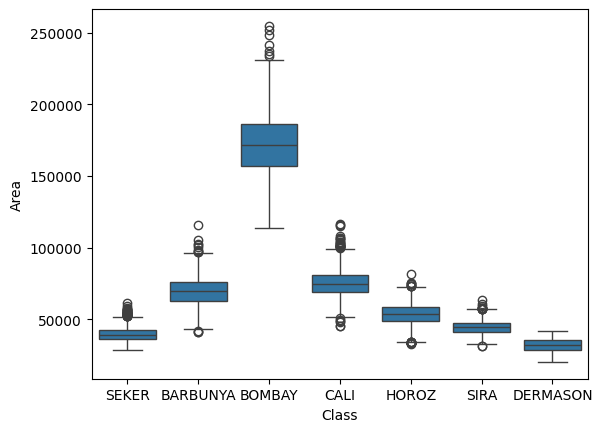

In [9]:
# Boxplot to visualize the distribution of the 'Area' feature for each class
sns.boxplot(x='Class', y='Area', data=data)

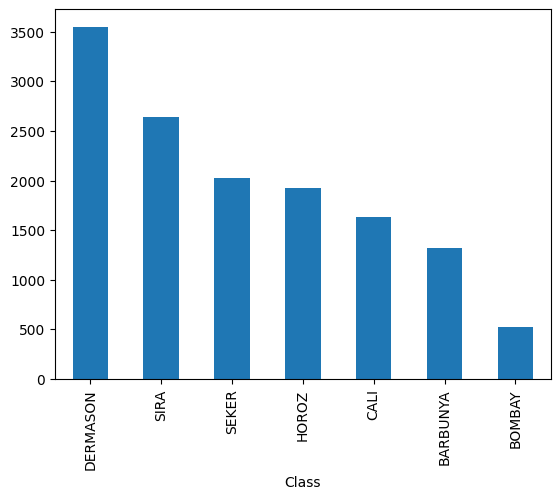

In [10]:
# Bar plot to visualize the distribution of different classes in the dataset
import matplotlib.pyplot as plt
data['Class'].value_counts().plot(kind='bar')
plt.show()

In [11]:
# Separate features (X) and target (y) variables
X = data.drop('Class', axis=1)
y = data['Class']

# Encode the target variable (y) as integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the feature variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
# Initialize machine learning models with hyperparameters for GridSearch
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': [ 'liblinear']
            ,'random_state': [42]
        }
     },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [10, 20, 30, None]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    }
    ,'xgboost': {
        'model': XGBClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30, None]
        }
     }
}

In [13]:
# Initialize an empty dictionary to store the best models for each algorithm
best_models = {}
# Iterate over each model name and its corresponding information
for model_name, model_info in models.items():
    # Perform Grid Search Cross-Validation to find the best hyperparameters
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=6, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    # Store the best estimator (model with optimal hyperparameters) in the dictionary
    best_models[model_name] = grid_search.best_estimator_

In [14]:
# Iterate over the best models and print their names and corresponding model objects
for model_name, model in best_models.items():
    print(f"Best {model_name}: {model}")

Best Logistic Regression: LogisticRegression(C=10, random_state=42, solver='liblinear')
Best Decision Tree: DecisionTreeClassifier(max_depth=10)
Best SVM: SVC(C=100)
Best KNN: KNeighborsClassifier(n_neighbors=7, weights='distance')
Best xgboost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softpr

In [15]:
# Iterate through the best models and evaluate their performance
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f"Model: {model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Model: Logistic Regression
[[233   0  15   0   1   1  11]
 [  0 117   0   0   0   0   0]
 [  9   0 300   0   4   0   4]
 [  0   0   0 598   2   7  64]
 [  1   0   3   5 390   0   9]
 [  7   0   0   8   0 388  10]
 [  1   0   1  37   5   4 488]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       261
           1       1.00      1.00      1.00       117
           2       0.94      0.95      0.94       317
           3       0.92      0.89      0.91       671
           4       0.97      0.96      0.96       408
           5       0.97      0.94      0.95       413
           6       0.83      0.91      0.87       536

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.94      2723
weighted avg       0.93      0.92      0.92      2723

Model: Decision Tree
[[225   0  25   0   1   1   9]
 [  0 117   0   0   0   0   0]
 [ 16   0 295   0   4   0   2]
 [  0   0   0 602   3  10  56]
 [  2   0  12

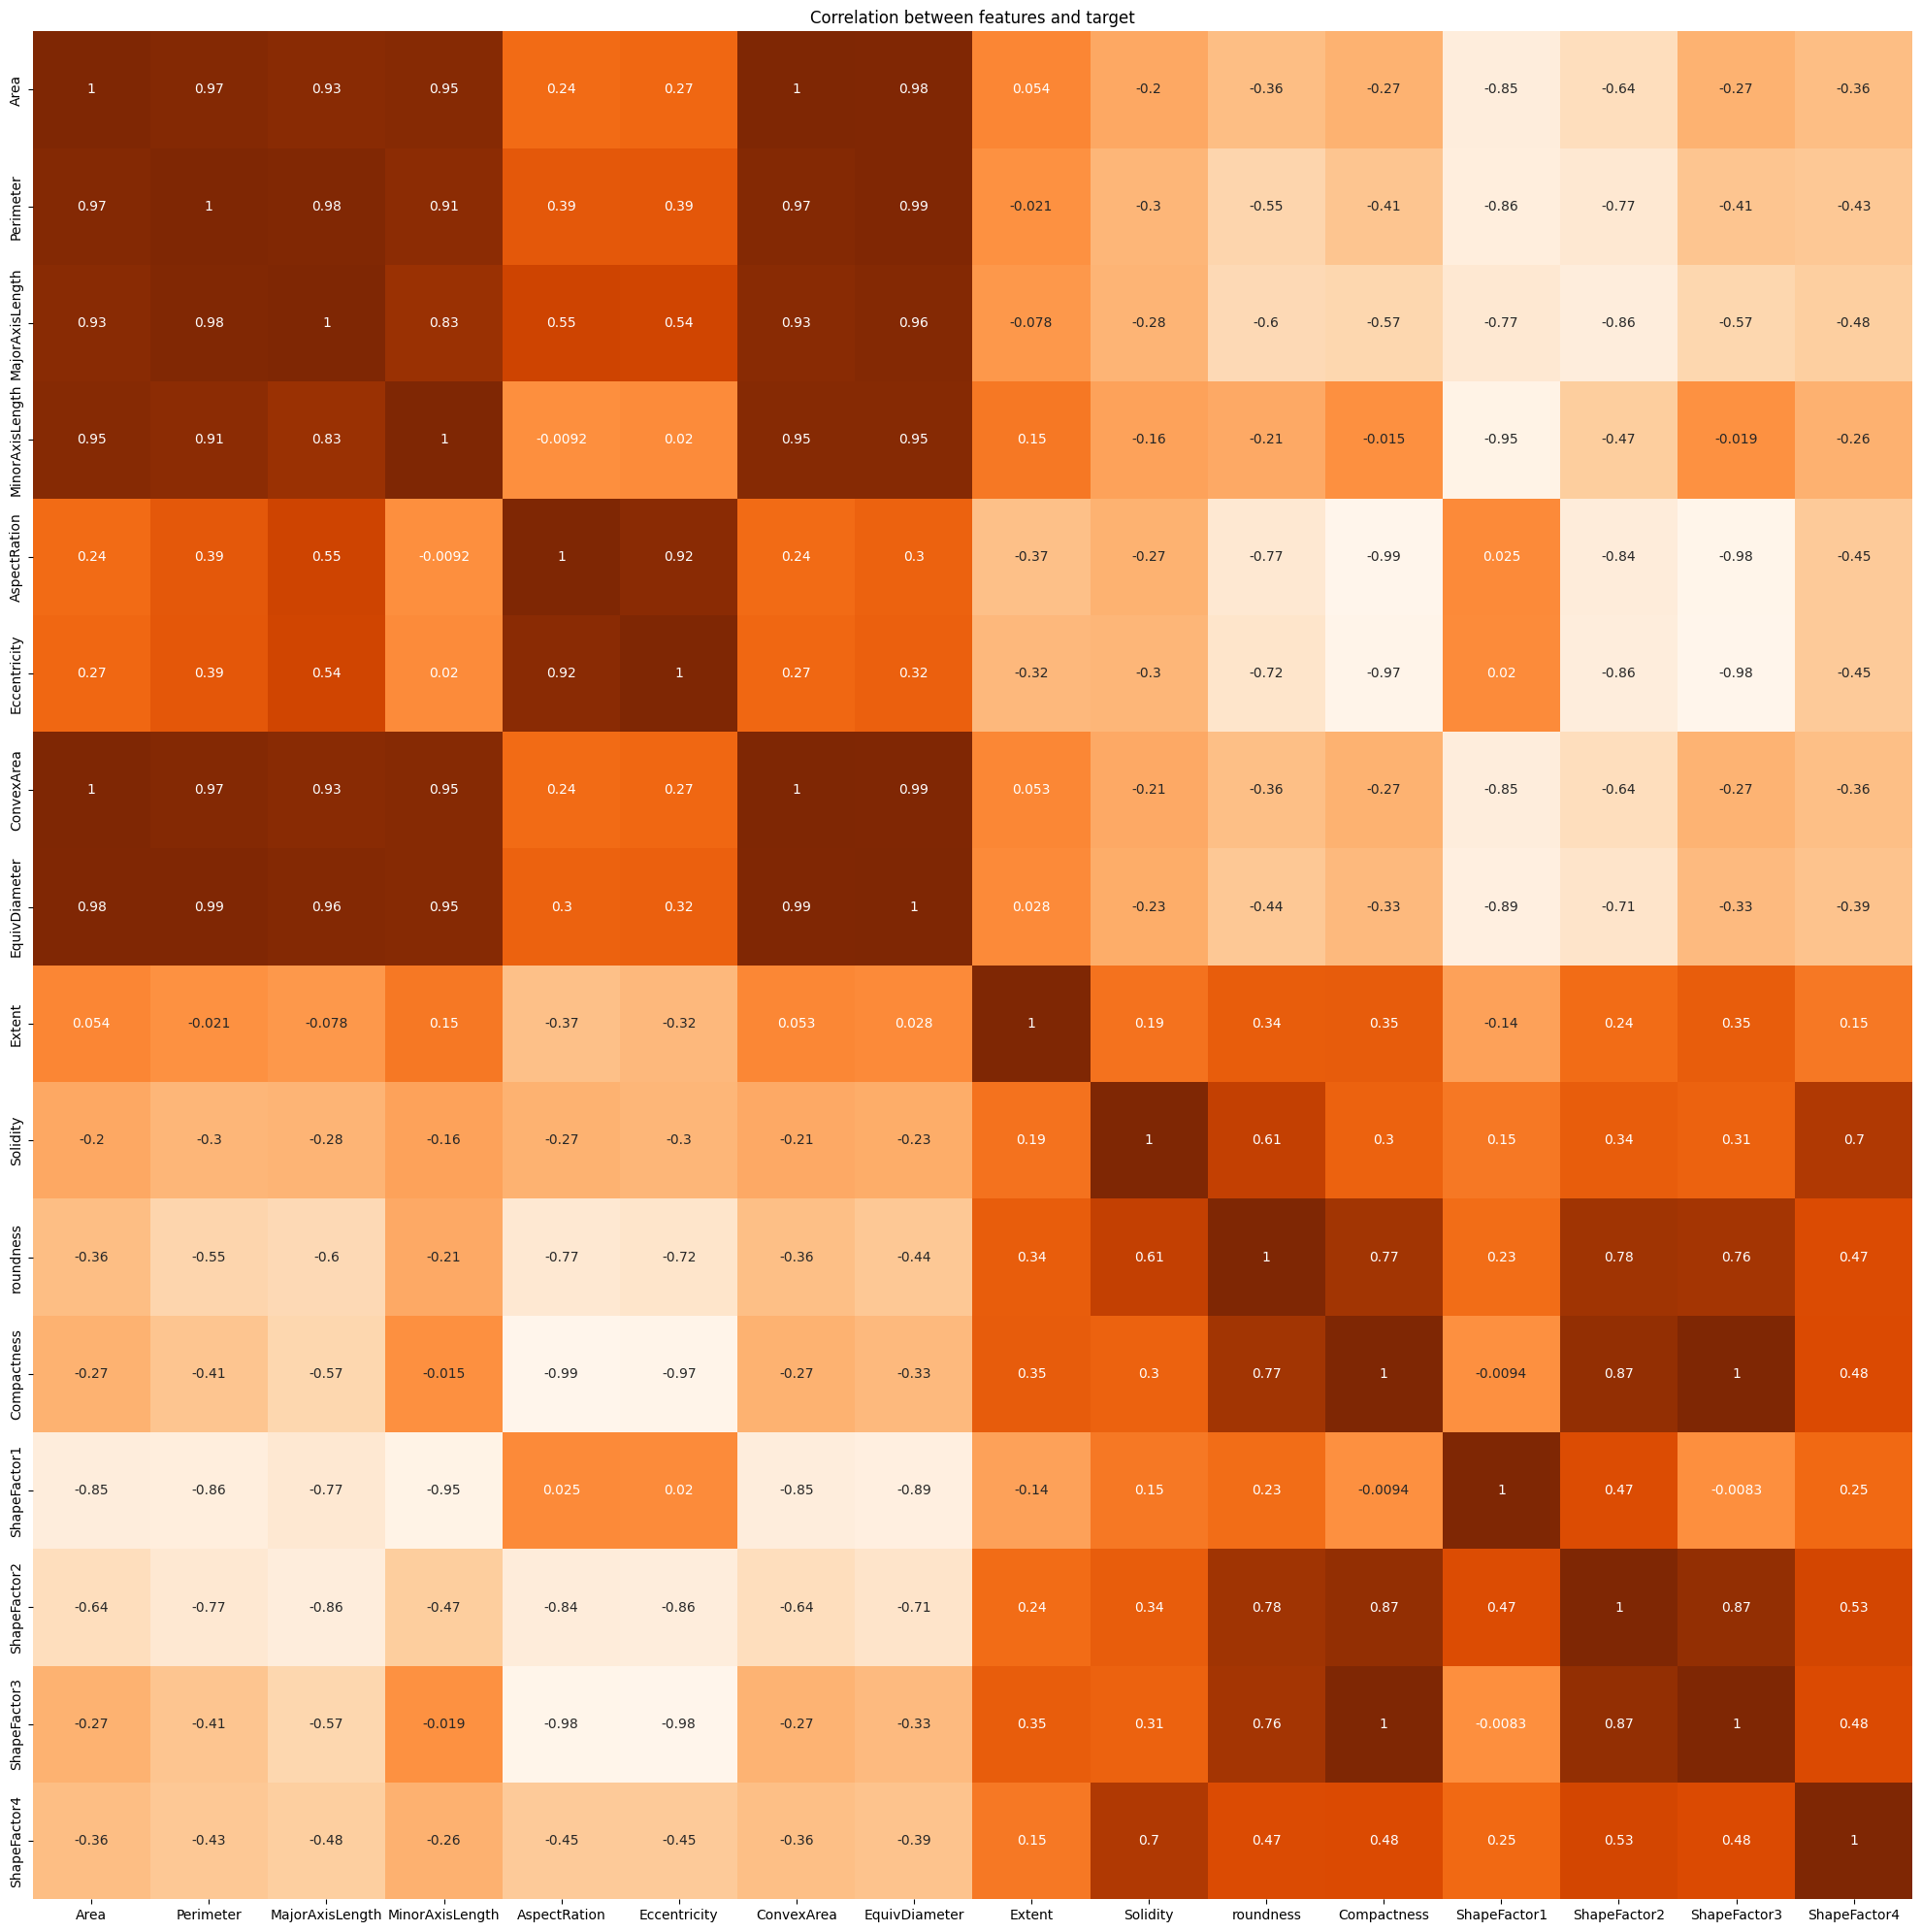

In [16]:
# Calculate the correlation matrix for numerical features
corr = data.select_dtypes(exclude=['object']).corr()
# Create a heatmap to visualize the correlations
plt.subplots(1,1, figsize=(25,25))
sns.heatmap(data=corr, cmap ='Oranges', annot = corr, cbar=None)
plt.title('Correlation between features and target')
plt.show()

In [17]:
# Get the absolute values of correlations
corr = corr.abs()

# Select the upper triangle of the correlation matrix
upper_triangle = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_))

# Identify columns with correlation greater than 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Drop highly correlated columns from the dataset
data_reduced = data.drop(columns=to_drop)

In [18]:
# Initialize machine learning models with hyperparameters for GridSearch
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': [ 'liblinear']
            ,'random_state': [42]
        }
     },
    # 'Decision Tree': {
    #     'model': DecisionTreeClassifier(),
    #     'params': {
    #         'criterion': ['gini', 'entropy'],
    #         'max_depth': [10, 20, 30, None]
    #     }
    # },
    # 'SVM': {
    #     'model': SVC(),
    #     'params': {
    #         'C': [0.1, 1, 10, 100],
    #         'kernel': ['linear', 'rbf']
    #     }
    # },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    }
    # ,'xgboost': {
    #     'model': XGBClassifier(),
    #     'params': {
    #         'n_estimators': [50, 100, 200],
    #         'max_depth': [10, 20, 30, None]
    #     }
    #  }
}

In [19]:
#reduce x_train and x_test

X_reduced = data_reduced.drop('Class', axis=1)
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
# Initialize an empty dictionary to store the best models for each algorithm
best_models = {}
# Iterate over each model name and its corresponding information
for model_name, model_info in models.items():
    # Perform Grid Search Cross-Validation to find the best hyperparameters
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=6, scoring='accuracy')
    grid_search.fit(X_train_reduced, y_train)
    # Store the best estimator (model with optimal hyperparameters) in the dictionary
    best_models[model_name] = grid_search.best_estimator_
# Iterate through the best models and evaluate their performance
for model_name, model in best_models.items():
    y_pred = model.predict(X_test_reduced)
    print(f"Model: {model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Model: Logistic Regression
[[  0   1 252   0   0   0   8]
 [  0 117   0   0   0   0   0]
 [  0   3 314   0   0   0   0]
 [  0   0   0   0   0   0 671]
 [  0   0 175   0   0   0 233]
 [  0   0  20   0   0   0 393]
 [  0   0  33   0   0   0 503]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       261
           1       0.97      1.00      0.98       117
           2       0.40      0.99      0.57       317
           3       0.00      0.00      0.00       671
           4       0.00      0.00      0.00       408
           5       0.00      0.00      0.00       413
           6       0.28      0.94      0.43       536

    accuracy                           0.34      2723
   macro avg       0.23      0.42      0.28      2723
weighted avg       0.14      0.34      0.19      2723

Model: KNN
[[ 80   0 125   1  44   1  10]
 [  0 117   0   0   0   0   0]
 [ 77   0 220   0  20   0   0]
 [  0   0   0 553   1  95  22]
 [ 40   0  20  10 224  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
y_train_categorical = to_categorical(y_train)
# Define the model architecture
model = Sequential()
# Add a dense layer with 64 units, ReLU activation, and specify input dimensions based on training data
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
# Add a Dropout layer to prevent overfitting by randomly setting 30% of input units to 0
model.add(Dropout(0.3))
# Add the output layer with units equal to the number of classes in the target, softmax activation for multi-class classification
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model using categorical crossentropy loss, adam optimizer, and accuracy as a metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping to prevent overfitting by stopping training when validation loss stops improving
#early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

# Train the model on the training data with 20% of the data used for validation
#history = model.fit(X_train, y_train_categorical, validation_split=0.2, epochs=20, batch_size=8, callbacks=[early_stopping])
history = model.fit(X_train, y_train_categorical, validation_split=0.2, epochs=20, batch_size=8)
# Convert test labels to categorical format
y_test_categorical = to_categorical(y_test)
# Predict the class probabilities for the test set
y_pred = model.predict(X_test)
# Convert predicted probabilities to class labels by selecting the index with the highest probability
y_pred = np.argmax(y_pred, axis=1)
# Identify the indices where the predictions do not match the actual test labels
incorrect_indices = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]

# Evaluate the model on the test set and print the test accuracy
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7084 - loss: 0.8805 - val_accuracy: 0.9164 - val_loss: 0.2653
Epoch 2/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8933 - loss: 0.2944 - val_accuracy: 0.9219 - val_loss: 0.2311
Epoch 3/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9047 - loss: 0.2643 - val_accuracy: 0.9242 - val_loss: 0.2253
Epoch 4/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9096 - loss: 0.2472 - val_accuracy: 0.9265 - val_loss: 0.2205
Epoch 5/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9165 - loss: 0.2297 - val_accuracy: 0.9242 - val_loss: 0.2156
Epoch 6/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9127 - loss: 0.2316 - val_accuracy: 0.9279 - val_loss: 0.2168
Epoch 7/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9157 - loss: 0.2339 - val_accuracy: 0.9265 - val_loss: 0.2121
Epoch 8/20
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9140 - loss: 0.2242 - 

In [25]:
y_pred_prob = model.predict(X_test)

y_pred = np.argmax(y_pred_prob, axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[240   0  15   0   0   1   5]
 [  0 117   0   0   0   0   0]
 [ 11   0 300   0   4   1   1]
 [  0   0   0 635   1   4  31]
 [  2   0   4   4 395   0   3]
 [  7   0   0  10   0 388   8]
 [  0   0   1  57  10   4 464]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       261
           1       1.00      1.00      1.00       117
           2       0.94      0.95      0.94       317
           3       0.90      0.95      0.92       671
           4       0.96      0.97      0.97       408
           5       0.97      0.94      0.96       413
           6       0.91      0.87      0.89       536

    accuracy                           0.93      2723
   macro avg       0.94      0.94      0.94      2723
weighted avg       0.93      0.93      0.93      2723

